In [53]:
import os
import json
import csv
import re
import pandas as pd
import sentence_transformers
import umap.umap_ as umap
import matplotlib.pyplot as plt
import altair as alt
import langdetect 
import numpy as np
import statistics

In [99]:
f = open('./rtfc_embed_list_full_2d.json')
data = json.load(f)
data

{'nodes': [{'id': 13780000000,
   'conversation': '1378',
   'convo_index': '00000',
   'rootx': 1292.8537387473912,
   'rooty': 506.01243411793433,
   'kmeans': 1,
   'speaker': 'Ceasar',
   'collection': '114',
   'convo_prop_index': 0.0,
   'words': "And this one to record, so we have two things recording right now. Great. I'm going to step right into the process, do the script and everything. First of all, I want to welcome you all here. Thank you for volunteering your time to join the Real Talk conversation. As you know, Real Talk For Change is really set up to make sure that we are getting the voices of people who are often unheard from in the political process, to get their voice actually considered and part of what's going on with these current elections. "},
  {'id': 13780000001,
   'conversation': '1378',
   'convo_index': '00001',
   'rootx': 1361.0890294991286,
   'rooty': 396.79622650146484,
   'kmeans': 11,
   'speaker': 'Ceasar',
   'collection': '114',
   'convo_prop_in

In [106]:


convo_dict = {}
master_list = {}
count = 0
master_count = 0
previous_speaker_id = 0
edge_list = []
past_convo = 0
total_word = 0
total_count = 0

for i in data['nodes']:
    convo = i['conversation']
    speaker = i['speaker']
    words = i['words'].split(" ")    
    
    if past_convo == convo:
        total_count += 1
        total_word += len(words)
    if past_convo != convo and past_convo != 0 or past_convo == 2838:
        word_average = []
        turn_average = []
        for u in convo_dict[past_convo]['speaker_nodes']:
            if u['convo'] == past_convo:
                u['total_count'] = total_count
                u['participant_count'] = len(convo_dict[past_convo]['speaker_nodes'])
                u['word_total_count'] = total_word
                u['turn_prop'] = u['turn_count']/u['total_count'] - 1/u['participant_count']
                u['word_prop'] = u['word_count']/u['word_total_count'] - 1/u['participant_count']                
                word_average.append(u['word_count']/u['word_total_count'] )
                turn_average.append(u['turn_count']/u['total_count'])               
        convo_dict[past_convo]['convo_features']['word_dist'] = statistics.stdev(word_average)
        convo_dict[past_convo]['convo_features']['turn_dist'] = statistics.stdev(turn_average)
        total_count = 1
        total_word = 0


    if convo not in convo_dict.keys():
        convo_dict[convo] = {'convo_features': {'word_dist': 0, 'turn_dist': 0},
                             'speaker_list': [],
                             'speaker_nodes': [],
                             'speaker_edges': []}  

    if speaker not in convo_dict[convo]['speaker_list']:
        if speaker in master_list.keys():
            master_list[speaker]['count'] += 1
        else:
            master_list[speaker] = {}
            master_list[speaker]['count'] = 1 
            master_list[speaker]['id'] = master_count
            master_count += 1
        convo_dict[convo]['speaker_list'].append(speaker)
        convo_dict[convo]['speaker_nodes'].append({
            'id': count,
            'convo': convo,            
            'name': speaker,
            'word_count': len(words),
            'turn_count': 1,
            'total_count': 0,
            'turn_prop': 0,            
            'word_prop': 0,                        
            'word_total_count': 0,            
            'participant_count': 0,            
            'global': master_list[speaker]
        })
        count += 1
#         total_word += len(words)
    else: 
        for h in convo_dict[convo]['speaker_nodes']:
            if h['name'] == speaker:
                h['turn_count'] += 1
                h['word_count'] += len(words)
    
 
    for y in convo_dict[convo]['speaker_nodes']:
        if y['name'] == speaker:
            speaker_id = y['id']

    if speaker_id != previous_speaker_id and past_convo == convo:
        if (previous_speaker_id, speaker_id) in edge_list:
            for x in convo_dict[convo]['speaker_edges']:
                if x["source"] == previous_speaker_id and x["target"] == speaker_id:
                    x['weight'] += 1
                    break
        else:
            convo_dict[convo]['speaker_edges'].append({'source': previous_speaker_id, 
                                 'target': speaker_id,
                                 'weight': 1})
            edge_list.append((previous_speaker_id, speaker_id))
        
    previous_speaker_id = speaker_id
    past_convo = convo
                                        
        
f.close()

In [127]:
# convo_dict.keys()
# print(convo_dict['1495'])

In [109]:
# convo_dict
turn_prop_list = []
word_prop_list = []
word_prop_convo_list = []
turn_prop_convo_list = []

for i in convo_dict:
    for x in convo_dict[i]['speaker_nodes']:
        turn_prop_list.append(x['turn_prop'])
        word_prop_list.append(x['word_prop'])  
    word_prop_convo_list.append(convo_dict[i]['convo_features']['word_dist'])
    turn_prop_convo_list.append(convo_dict[i]['convo_features']['turn_dist'])    


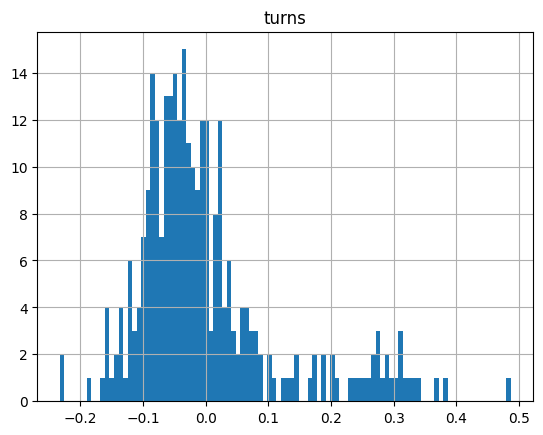

In [110]:
df_mini = pd.DataFrame({
    'turns': turn_prop_list
    })
hist = df_mini.hist(bins=100)

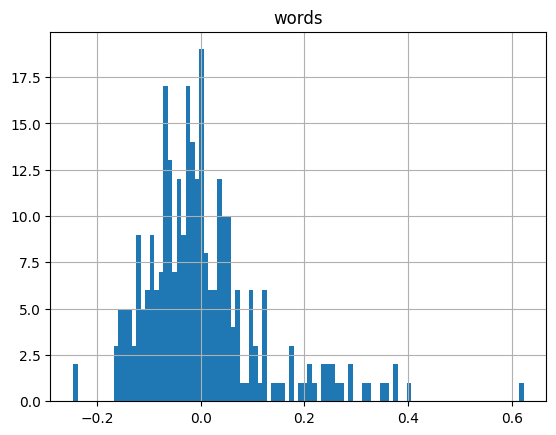

In [111]:
df_mini = pd.DataFrame({
    'words': word_prop_list
    })
hist = df_mini.hist(bins=100)

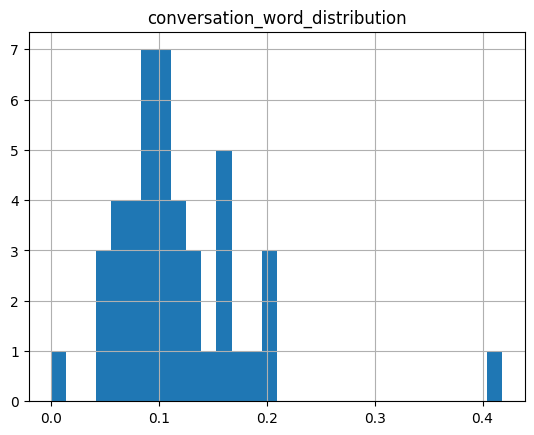

In [112]:
df_mini = pd.DataFrame({
    'conversation_word_distribution': word_prop_convo_list
    })
hist = df_mini.hist(bins=30)

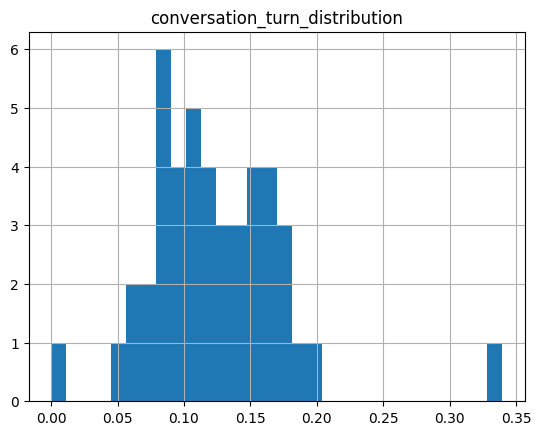

In [114]:
df_mini = pd.DataFrame({
    'conversation_turn_distribution': turn_prop_convo_list
    })
hist = df_mini.hist(bins=30)

In [66]:
big_dict = {'nodes': [],
            'edges': []}
for i in convo_dict:
    for j in convo_dict[i]['speaker_nodes']:
        big_dict['nodes'].append(j)
    for h in convo_dict[i]['speaker_edges']:
        big_dict['edges'].append(h)       

In [ ]:
big_dict

In [ ]:
with open('./convo_turns.json', 'w') as f:
    json.dump(big_dict, f) 